# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

In [2]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [3]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)+1
test_data, test_labels = newsgroups_test.data[num_test//2:], newsgroups_test.target[num_test//2:]
dev_data, dev_labels = newsgroups_test.data[:num_test//2], newsgroups_test.target[:num_test//2]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('test label shape:', test_labels.shape)
print('dev label shape:', dev_labels.shape)
print('labels names:', newsgroups_train.target_names)

training label shape: (2034,)
test label shape: (676,)
dev label shape: (677,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


**(1)** For each of the first 5 training examples, print the text of the message along with the label.

[2 pts]

In [4]:
def P1(num_examples=5):
    
### STUDENT START ###

    # Train data with label
    for i in range(num_examples):
        print('\nLabel:', newsgroups_train.target_names[train_labels[i]])
        print('\nText:\n')
        print(train_data[i]) 

### STUDENT END ###

P1(5)


Label: comp.graphics

Text:

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych

Label: talk.religion.misc

Text:



Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuri

**(2)** Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

[6 pts]

In [5]:
def P2():

### STUDENT START ###

    # A) Count vectorize - fit vocab and transform to feature vectors
    cv1 = CountVectorizer()
    train_vector = cv1.fit_transform(train_data)

    print('a)')
    print('Vocabulary size:', train_vector.shape[1])
    print('Average non-zero features: {:.2f}'.format(train_vector.getnnz() / train_vector.shape[0]))
    print('Fraction of non-zero entries: {:.4f}\n'.format(train_vector.getnnz() / (train_vector.shape[0] * train_vector.shape[1])))
    
    # B) Feature names
    print('b)')
    print('First feature: {}'.format(cv1.get_feature_names()[0]))
    print('Last feature: {}\n'.format(cv1.get_feature_names()[-1]))
    
    # C) Custom vocabulary vectorize
    custom_vocab = ['atheism', 'graphics', 'space', 'religion']
    cv2 = CountVectorizer(vocabulary = custom_vocab)
    custom_vector = cv2.fit_transform(train_data)
    
    print('c)')
    print('Vocabulary size:', custom_vector.shape[1])
    print('Average non-zero features: {:.4f}\n'.format(custom_vector.getnnz() / custom_vector.shape[0]))
    
    # D) Bigram-trigram characters vectorize
    cv3 = CountVectorizer(ngram_range = (2,3), analyzer = 'char')
    chars_vector = cv3.fit_transform(train_data)
    
    print('d)')
    print('Vocabulary size (bigram/trigram chars): {}\n'.format(chars_vector.shape[1]))
    
    # E) Min doc frequency - 10 words
    cv4 = CountVectorizer(min_df = 10)
    mindf_vector = cv4.fit_transform(train_data)
    
    print('e)')
    print('Vocabulary size (min document freq of 10): {}\n'.format(mindf_vector.shape[1]))
    
    # F) 
    cv5 = CountVectorizer()
    dev_vector = cv5.fit_transform(dev_data)

    # Feature words difference between train and dev
    word_difference = list(set(cv5.get_feature_names()) - set(cv1.get_feature_names()))
    
    print('f)')
    print('Fraction of dev words missing from train: {:.4f}'.format(len(word_difference)/len(cv5.get_feature_names())))

### STUDENT END ###
      
P2()

a)
Vocabulary size: 26879
Average non-zero features: 96.71
Fraction of non-zero entries: 0.0036

b)
First feature: 00
Last feature: zyxel

c)
Vocabulary size: 4
Average non-zero features: 0.2684

d)
Vocabulary size (bigram/trigram chars): 35478

e)
Vocabulary size (min document freq of 10): 3064

f)
Fraction of dev words missing from train: 0.2479


**(3)** Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

[4 pts]

In [6]:
def optimize_classifier(model_text, pipe, param_grid, train_data=train_data, train_labels=train_labels, dev_data=dev_data, dev_labels=dev_labels):
    '''Text classifier optimizer that incorporates grid search.
    Accepts inputs of model (string), pipeline (list of tuples)
    and parameter grid (dictionary of nested lists). 
    Outputs the best parameters and f1 score.    
    '''

    # Fit model using GridSearch
    grid_search = GridSearchCV(pipe, param_grid, cv=3)
    grid_search.fit(train_data, train_labels)
    predictions = grid_search.predict(dev_data)

    # Best parameter and score for select models
    if model_text == 'knn':
        print('K-nearest-neighbors')
        print('Best n:', grid_search.best_params_['clf__n_neighbors'])
        print('F1 score: {:.3f}'.format(metrics.f1_score(dev_labels, predictions, average='micro')))
        
    elif model_text == 'multi_nb':
        print('\nMultinomial NB')
        print('Best alpha:', grid_search.best_params_['clf__alpha'])
        print('F1 score: {:.3f}'.format(metrics.f1_score(dev_labels, predictions, average='micro')))
        
    elif model_text == 'logreg':
        print('\nLogistic regression')
        print('Best C:', grid_search.best_params_['clf__C'])
        print('F1 score: {:.3f}'.format(metrics.f1_score(dev_labels, predictions, average='micro')))
  

In [18]:
def logreg_coef(parameter, train_data=train_data, train_labels=train_labels, dev_data=dev_data, dev_labels=dev_labels):
    '''Logistic regression model optimized with grid search
    for various C. Accepts a dictionary containing a nested list
    and outputs the best parameter and f1 score.    
    '''
    
    # Count vectorize train data
    cv = CountVectorizer()
    vector = cv.fit(train_data)

    # Create train and dev vectors
    train_vector = vector.transform(train_data)
    dev_vector = vector.transform(dev_data)
    
    # Print table header
    print('\n{:<8s} {:>10s}'.format('C', 'Sum of Squared Coefs'))

    # Loop through various C values
    for i in range(len(parameter['C'])):
        
        # Fit logistic regression model
        logreg = LogisticRegression(penalty = 'l2', C = parameter['C'][i])
        logreg.fit(train_vector, train_labels)

        # Sum of squared coefficients
        coef_squared_sum = np.square(logreg.coef_).sum()

        # C value and sum of squared coefficients
        print('{:<8s} {:>.4f}'.format(str(parameter['C'][i]), coef_squared_sum))

In [19]:
def P3():
    
### STUDENT START ###

    # KNN pipeline
    pipe_knn = Pipeline([('cv', CountVectorizer()),
                         ('clf', KNeighborsClassifier())])

    # Parameters for optimization
    parameters_knn = {'clf__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]}

    # Optimize KNN
    optimize_classifier('knn', pipe_knn, parameters_knn)

    # MultinomialNB pipeline
    pipe_nb = Pipeline([('cv', CountVectorizer()),
                        ('clf', MultinomialNB())])

    # Parameters for optimization
    parameters_nb = {'clf__alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 2, 5, 10]}
    

    # Optimize MultinomialNB
    optimize_classifier('multi_nb', pipe_nb, parameters_nb)

    # Logistic regression pipeline
    pipe_logreg = Pipeline([('cv', CountVectorizer()),
                            ('clf', LogisticRegression())])

    # Parameters for optimization
    parameters_logreg = {'clf__C': [0.0001, 0.001, 0.01, 0.1, 1, 5, 10],
                         'clf__penalty': ['l2']}

    # Optimize logistic regression
    optimize_classifier('logreg', pipe_logreg, parameters_logreg)
    
    # Print C values and sum of squared coefs
    logreg_coef(parameter = {'C': parameters_logreg['clf__C']})

### STUDENT END ###

P3()

K-nearest-neighbors
Best n: 19
F1 score: 0.439

Multinomial NB
Best alpha: 0.01
F1 score: 0.780

Logistic regression
Best C: 0.1
F1 score: 0.705

C        Sum of Squared Coefs
0.0001   0.0382
0.001    0.7340
0.01     10.5937
0.1      102.2704
1        601.4486
5        1513.0279
10       2102.8214


**ANSWER:**

a) KNN perform poorly in this context because it is being applied to a sparse matrix with high dimensionality data.  In this dataset there are a total of 26,879 words in the dataset which means the features vectors have a length of 26,879, comprised mostly of zeros because most words won't appear in each of these short text excerpts.  This results in feature vectors that are very similar to one another.  This causes complications for the nearest neighbors classifier because each feature vector is a remarkably similar distance away from the sample being classified, increasing the likelihood of misclassification.

b) Naive Bayes and logistic regression differ from each other in a few notable ways. Naive Bayes assumes conditional independence between each of the features vectors weights and so if there is a high-degree of correlation between certain words a a given label this model would be prone to bias.  Logistic regression is however less prone to such biases because the coefficient weights accounts for the correlation between input features.  In the case of our bag-of-words example it's likely that certain words are good predictors of a particular news category are also correlated.  As Naive Bayes outperforms logistic regression (0.780 vs. 0.705) then it's quite likely that the dataset follows this bias.

An additional distinction is that Naive Bayes is a generative classifier that learns the joint probabilities of the inputs and labels, and then makes predictions using the calculated posteriors, P(y|x).  Logistic regression is a discrimative classifier that estimates the probability of P(y|x) directly from the data.  My research also suggests that generative models tend to perform better with less training data compared to discrimative models but we have 2,034 training samples so this point may be mute.

c) The logistic regression model used applies 'L2 Regularization' to mitigate against overfitting.  In the case of ridge regression, the penalty term added is the sum of the squared magnitude of the coefficients.  A smaller C value represents stronger regularization, and as such results in smaller coefficients weights because the relationship between the predictors and response variables is more conservative.  This explains is why the sum of squared coefficients increases as the value of C increases.

**(4)** Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

[5 pts]

In [9]:
def coefficients_table(ngram_range=(1,1)):
    
    # Count vectorize train data
    cv = CountVectorizer(ngram_range=ngram_range, analyzer='word')
    vector = cv.fit(train_data)

    # Create train and dev vectors
    train_vector = vector.transform(train_data)
    dev_vector = vector.transform(dev_data)

    # Fit logistic regression model
    logreg = LogisticRegression(penalty = 'l2', C = 0.1)
    logreg.fit(train_vector, train_labels)
    predictions = logreg.predict(dev_vector)

    top_20 = []

    # Loop through label coefficients
    for i in range(logreg.coef_.shape[0]):

        # Indices of top 5 coefficient weights for given
        # label are combined to create top 20 coef indices.
        top_20.extend(logreg.coef_[i].argsort()[-5:][::-1])

    # Container for coefficients
    coef_grid = []

    # Loop through each label's coefficients
    for label in logreg.coef_:

        label_coefs = []

        # Loop through indices of top 20 weights and extract
        # the corresponding coefficient value for each label.

        for weight in top_20:
            label_coefs.append(label[weight])

        # Weights for current label
        coef_grid.append(label_coefs)

    # All label weights
    np.array(coef_grid).shape

    # Label names
    label_names = newsgroups_train.target_names

    # Words corresponding to top 20 weights
    ngrams = [cv.get_feature_names()[i] for i in top_20]

    # Meaningful names for label weights
    atheism = coef_grid[0]
    graphics = coef_grid[1]
    space = coef_grid[2]
    religion = coef_grid[3]

    # Create dataframe
    coefficients_table = pd.DataFrame({label_names[0]: atheism, 
                                       label_names[1]: graphics,
                                       label_names[2]: space,
                                       label_names[3]: religion},
                                       index = ngrams)
    return coefficients_table

In [10]:
def P4():
    
### STUDENT START ###

    print('\nNgram = 1')
    print(coefficients_table(ngram_range=(1,1)))

    print('\nNgram = 2')
    print(coefficients_table(ngram_range=(2,2)))

### STUDENT END ###

P4()


Ngram = 1
            alt.atheism  comp.graphics  sci.space  talk.religion.misc
atheism        0.495307      -0.207269  -0.199901           -0.267745
religion       0.493895      -0.298790  -0.393228            0.003773
bobby          0.478167      -0.120389  -0.167846           -0.227796
atheists       0.461036      -0.079433  -0.158394           -0.295295
islam          0.426336      -0.084812  -0.165052           -0.164903
graphics      -0.411184       1.007501  -0.651124           -0.372188
image         -0.263555       0.642105  -0.367637           -0.216024
file          -0.177350       0.641218  -0.421579           -0.288260
computer      -0.039839       0.559006  -0.329044           -0.228732
3d            -0.182022       0.546980  -0.311635           -0.181417
space         -0.655149      -0.714048   1.258827           -0.590157
orbit         -0.217582      -0.334080   0.597334           -0.248916
nasa          -0.273324      -0.261773   0.540889           -0.253069
launch   

**ANSWER:**

There are a couple of interesting features when comparing the unigram and bigram coefficient tables.  The unigram table generated an output that I expect, with the words asociated with the top 5 coefficients weights for a given label are clearly good predictors of that category, e.g. space is indicative of the 'sci.space' category. The coefficient for the other categories for these same words are negative, i.e. space is a good indicator that the category is not 'comp.graphics'.

In the bigram table the 5 features that are the best indicator of a particular category all have lower coeffients weights than their unigram equivalents so predicting capability appears to have decreased.  Additionally, there are a number bigram features that look out of place in this list such as 'cheers kent' and 'are you', neither of which would seemingly indicate a particular news category. Furthermore, 'cheers kent' is top bigram for both categories 'alt'atheism' and 'talk.religion.misc' confirming it is not a clear indicator of a single category.

**(5)** Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

[4 pts]

In [11]:
def preprocessor_score(preprocessor, stop_words = None):

    # Count vectorize train data
    cv = CountVectorizer(preprocessor=preprocessor, stop_words = stop_words)
    vector = cv.fit(train_data)

    # Create train and dev vectors
    train_vector = vector.transform(train_data)
    dev_vector = vector.transform(dev_data)

    # Fit logistic regression model
    logreg = LogisticRegression(penalty='l2', C = 0.1)
    logreg.fit(train_vector, train_labels)
    predictions = logreg.predict(dev_vector)
    
    return metrics.f1_score(dev_labels, predictions, average='micro')

In [12]:
def empty_preprocessor(s):
    return s

def better_preprocessor(s):
    
    # Remove underscores
    processed_text = re.sub(r'_', '', s)
    
    # Remove parentheses
    processed_text = re.sub(r'[()]', '', processed_text) 

    # Replace whitespace chars with space
    processed_text = re.sub(r'[^\w]', ' ', processed_text)
    
    # Replace digits with token
    processed_text = re.sub(r'[0-9]', '#99' , processed_text)
    
    # Make lowercase - decreased accuracy
    #processed_text = processed_text.lower()
    
    # Remove email addressese - decreased accuracy
    #processed_text = re.sub(r'\S*@\S*\s?', ' ', processed_text)

    return processed_text

### STUDENT END ###

def P5():
    
### STUDENT START ###

    empty = preprocessor_score(preprocessor = empty_preprocessor)
    better = preprocessor_score(preprocessor = better_preprocessor)
    better_stopwords = preprocessor_score(preprocessor = better_preprocessor, stop_words = 'english')

    print('Empty preprocessor: {:.4f}'.format(empty))
    print('Better preprocessor: {:.4f}'.format(better))
    print('Better with stopwords: {:.4f}'.format(better_stopwords))
    
### STUDENT END ###

P5()

Empty preprocessor: 0.7090
Better preprocessor: 0.7164
Better with stopwords: 0.7386


**(6)** The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

[4 pts]

In [13]:
def logreg_non_zeros(penalty, C):
    
    # Count vectorize train data
    cv = CountVectorizer()
    vector = cv.fit(train_data)

    # Create train and dev vectors
    train_vector = vector.transform(train_data)
    dev_vector = vector.transform(dev_data)

    # Fit logistic regression model
    logreg = LogisticRegression(penalty = penalty, C = C, tol=0.01)
    logreg.fit(train_vector, train_labels)
    predictions = logreg.predict(dev_vector)

    # List of coef non-zero counts
    non_zero = [np.count_nonzero(label) for label in logreg.coef_]
    print('{} non-zero coefs: {}'.format(penalty.upper(), np.sum(non_zero)))

In [14]:
def active_vocabulary(coefs):
    '''Accepts a the coeffcients from a logistic regression model
    and return the unique indices of the non-zero coefficients'''
    
    # Extract non-zero coefs
    non_zero_nested = np.array([np.nonzero(label) for label in coefs])
    non_zero = [index for label in non_zero_nested for index in label]

    # Flattened non-zeros
    non_zero_flat = []
    for label in non_zero:
        non_zero_flat.extend(label)

    # Unique non-zeros
    return np.unique(non_zero_flat)

In [15]:
def vocab_on_accuracy(C):

    l1_vocab_size = []
    l2_vocab_size = []
    l2_accuracy = []

    # Count vectorize train data
    cv1 = CountVectorizer()
    vector_l1 = cv1.fit(train_data)

    # Create train and dev vectors
    train_vector_l1 = vector_l1.transform(train_data)
    dev_vector_l1 = vector_l1.transform(dev_data)

    # Loop through C values for plot
    for i in range(len(C)):

        # Fit logistic regression model
        logreg_l1 = LogisticRegression(penalty = 'l1', C = C[i], tol=0.01)
        logreg_l1.fit(train_vector_l1, train_labels)
        predictions = logreg_l1.predict(dev_vector_l1)
        
        # Active vocabulary in L1 model, i.e. words with non-zero weights
        l1_vocab = np.sum([np.count_nonzero(label) for label in logreg_l1.coef_])
        
        # Active vocabulary in L1 model, i.e. words with non-zero weights
        active_vocab = active_vocabulary(coefs = logreg_l1.coef_)
        l1_vocab_names = [cv1.get_feature_names()[i] for i in active_vocab]
        
        # Create second count vectorizer using L1 vocabularly only
        cv2 = CountVectorizer(vocabulary = l1_vocab_names)
        vector_l2 = cv2.fit(train_data)
        
        # Create train and dev vectors
        train_vector_l2 = vector_l2.transform(train_data)
        dev_vector_l2 = vector_l2.transform(dev_data)

        # Fit logistic regression model
        logreg_l2 = LogisticRegression(penalty = 'l2', C = C[i], tol=0.01)
        logreg_l2.fit(train_vector_l2, train_labels)
        predictions = logreg_l2.predict(dev_vector_l2)
        
        # Active vocabulary in L1 model, i.e. words with non-zero weights
        l2_vocab = np.sum([np.count_nonzero(label) for label in logreg_l2.coef_])
        
        # Store L1 and L2 vocab sizes and L2 accuracy
        l1_vocab_size.append(l1_vocab)
        l2_vocab_size.append(l2_vocab)
        l2_accuracy.append(metrics.f1_score(dev_labels, predictions, average='micro'))
    
    # Plot accuracy
    fig, ax = plt.subplots(figsize = (6,4))
    plt.plot(l2_vocab_size, l2_accuracy)

    ax.set_title('L2 Regularization: Model Accuracy')
    plt.ylabel('F1-score')
    plt.xlabel('Vocabulary size')

Different regularizations where C = 0.1
L1 non-zero coefs: 360
L2 non-zero coefs: 107516


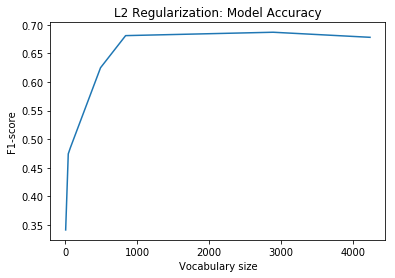

In [16]:
def P6():

    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

    ### STUDENT START ###

    # Non-zero vector coefs for different regularizations
    print('Different regularizations where C = 0.1')
    logreg_non_zeros(penalty = 'l1', C = 0.1)
    logreg_non_zeros(penalty = 'l2', C = 0.1)

    vocab_on_accuracy(C = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1])

### STUDENT END ###

P6()

**(7)** Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

[4 pts]

In [17]:
def P7():

    ### STUDENT START ###

    #  Tfidf vectorize train data
    vectorizer = TfidfVectorizer()
    vector = vectorizer.fit(train_data)

    # Create train and dev vectors
    train_vector = vector.transform(train_data)
    dev_vector = vector.transform(dev_data)

    # Fit logistic regression model
    logreg = LogisticRegression(C = 100)
    logreg.fit(train_vector, train_labels)
    pred_labels = logreg.predict(dev_vector)
    pred_probs = logreg.predict_proba(dev_vector)

    max_probs = []
    max_index = []

    # Predicted probability
    for i in range(dev_vector.shape[0]):
        max_i = np.argmax(pred_probs[i])
        max_probs.append(pred_probs[i][max_i])
        max_index.append(max_i)

    max_probs = np.asarray(max_probs)

    # Correct probability
    correct_probs = []
    for i in range(dev_labels.shape[0]):
        correct_probs.append(pred_probs[i][dev_labels[i]])

    # Calculate r ratio 
    r_ratio = max_probs / correct_probs

    # Indices of top 3 ratios
    max_ratios = r_ratio.argsort()[-3:][::-1]

    # Descriptive info about misclassified examples
    for i in max_ratios:
        print('\nError ratio: {:.5f}'.format(r_ratio[i]))
        print('Correct label: {}'.format(newsgroups_train.target_names[dev_labels[i]]))
        print('Predicted label:', newsgroups_train.target_names[max_index[i]])
        print('\nText:\n')
        print('{}\n'.format(dev_data[i]))
        print('-----'*15)

### STUDENT END ###

P7()


Error ratio: 929.35763
Correct label: talk.religion.misc
Predicted label: comp.graphics

Text:

I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people are welcome
to make *verbatim* copies for personal use. People can recuperate the
actual costs of printing (paper, copy center charges), but may not charge
anything for their time in making copies, or in any way realize a profit
from the

**ANSWER:**

Gauging by the outputted text for the first two documents with the highest r ratio, it seems like the presence of certain technical words is causing the logistic regression model to misclassify these examples as comp.graphics.  Words such as ftp, rich text format, ASCII, internet and online presumably all have large positive weights associated with the comp.graphics label across the entire corpus of text within train_data.

The third document should have been classified as alt.atheism but in fact was misclassified as talk.religion.misc.  It's a little different than the other two documents because intuitively it seems like none of the words appear to be better indicators of talk.religion.misc compared to alt.atheism.  One possible explanation is that 'ambiguous' words such as eight, two and children (for example) may have larger weights associated with the talk.religion.misc category simply because they happen to appear in more of the training examples for that label, resulting in misclassification.

One possible solution is to prune those features which do not have a particularly strong weight associated with a single label, i.e. those words that are not good indicators of a certain category.  Additionally, features prime for pruning could be defined as those which are good indicators of a particular category but that also appear frequently in other categories, resulting in misclassification more often (as obeserved in the two documents with the high error ratios).  Removal of such words would reduce the likelihood of a document being misclassified while allowing other features that are good predictors of a given label to take effect.


(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.

- [1 pt] for a reasonable attempt
- [2 pts] for improved performance